In [27]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio
from shapely.geometry import box, Point
from matplotlib.colors import Normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# -------------------------------
# Load FERP stem data
# -------------------------------
ferp_path = '../data/ferp/geoforest/doi_10_5061_dryad_6q573n64s__v20240129/FERP123merged_20231029.csv'
df = pd.read_csv(ferp_path)
df_geo = df.dropna(subset=["east_UTM", "north_UTM"]).copy()
gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo["east_UTM"], df_geo["north_UTM"]),
    crs="EPSG:32610"
)

# -------------------------------
# Load EnMAP hyperspectral cube
# -------------------------------
enmap_path = "../data/ferp/enmap/ENMAP01-____L2A-DT0000007897_20230215T193730Z_021_V010303_20230823T164547Z-SPECTRAL_IMAGE_COG.tiff"
with rasterio.open(enmap_path) as src:
    image = src.read()  # shape: (bands, height, width)
    transform = src.transform
    enmap_crs = src.crs
    width, height = src.width, src.height

# Stretch RGB for visualization
def stretch_rgb(rgb):
    vmin, vmax = np.percentile(rgb[rgb > -32768], [2, 98])
    return np.clip((rgb - vmin) / (vmax - vmin), 0, 1)

rgb_image = image[[44, 28, 9], :, :]
rgb_stretched = stretch_rgb(rgb_image)
rgb_plot = np.transpose(rgb_stretched, (1, 2, 0))  # H x W x 3
rgb_image_stretched = rgb_plot  # for compatibility

enmap_xmin = transform.c
enmap_xmax = transform.c + transform.a * width
enmap_ymax = transform.f
enmap_ymin = transform.f + transform.e * height
extent = [enmap_xmin, enmap_xmax, enmap_ymin, enmap_ymax]

# -------------------------------
# Reproject stem data and build grid
# -------------------------------
gdf_all = gdf.to_crs(enmap_crs)

# Build grid aligned with EnMAP pixels
pixel_width = transform.a
pixel_height = -transform.e
origin_x = transform.c
origin_y = transform.f

grid_cells = []
for row in range(height):
    for col in range(width):
        x0 = origin_x + col * pixel_width
        x1 = x0 + pixel_width
        y1 = origin_y - row * pixel_height
        y0 = y1 - pixel_height
        grid_cells.append(box(x0, y0, x1, y1))

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=enmap_crs)

# Spatial join: link stems to grid pixels
joined = gpd.sjoin(gdf_all, grid, how="left", predicate="within").dropna(subset=["index_right"])
species_counts = (
    joined.groupby(["index_right", "code6"]).size().unstack(fill_value=0)
)
grid = grid.join(species_counts, how="left").fillna(0)

# -------------------------------
# Compute FERP boundary
# -------------------------------
df_q = df.dropna(subset=["quadrat"])
def parse_quadrat(q): return tuple(map(int, q.replace("E", "").split("_N")))
df_q["east_quadrat"], df_q["north_quadrat"] = zip(*df_q["quadrat"].map(parse_quadrat))

unique_quads = df_q[["east_quadrat", "north_quadrat"]].drop_duplicates()
quad_gdf = gpd.GeoDataFrame(
    unique_quads,
    geometry=[box(e, n, e + 20, n + 20) for e, n in zip(unique_quads["east_quadrat"], unique_quads["north_quadrat"])],
    crs="EPSG:32610"
)

ferp_boundary_utm = gpd.GeoDataFrame(
    geometry=[gdf_all.unary_union.minimum_rotated_rectangle],
    crs=gdf_all.crs
)
ferp_boundary_enmap = ferp_boundary_utm.to_crs(grid.crs)

# Filter EnMAP grid to pixels inside FERP
grid = grid[grid.geometry.within(ferp_boundary_enmap.geometry.iloc[0])]

/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:29:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 74, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8396
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364532 -> initscore=-0.555747
[LightGBM] [Info] Start training from score -0.555747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:29:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 71, number of negative: 46
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8370
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339713 -> initscore=-0.664574
[LightGBM] [Info] Start training from score -0.664574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 103, number of negative: 14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8389
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.710345 -> initscore=0.897059
[LightGBM] [Info] Start training from score 0.897059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:29:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 91, number of negative: 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8365
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 219
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538462 -> initscore=0.154151
[LightGBM] [Info] Start training from score 0.154151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/dangause/Desktop/calacademy/hrs_botany/rs-hsi-botany/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_23797/1492766610.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


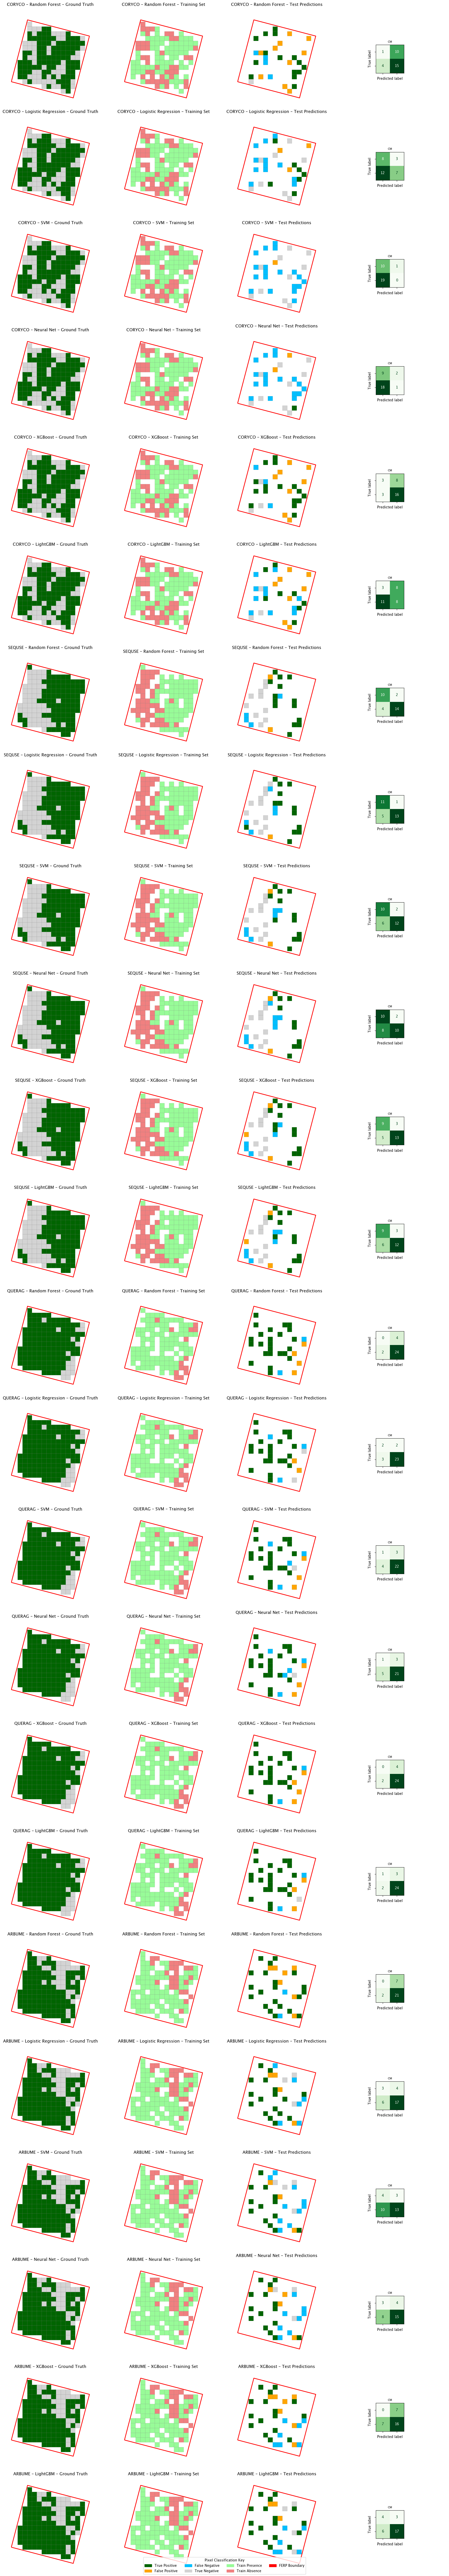

,species,model,accuracy,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1
0,CORYCO,Random Forest,0.533333,0.200000,0.090909,0.125000,0.600000,0.789474,0.681818
1,CORYCO,Logistic Regression,0.500000,0.400000,0.727273,0.516129,0.700000,0.368421,0.482759
2,CORYCO,SVM,0.333333,0.344828,0.909091,0.500000,0.000000,0.000000,0.000000
3,CORYCO,Neural Net,0.333333,0.333333,0.818182,0.473684,0.333333,0.052632,0.090909
4,CORYCO,XGBoost,0.633333,0.500000,0.272727,0.352941,0.666667,0.842105,0.744186
5,CORYCO,LightGBM,0.366667,0.214286,0.272727,0.240000,0.500000,0.421053,0.457143
6,SEQUSE,Random Forest,0.800000,0.714286,0.833333,0.769231,0.875000,0.777778,0.823529
7,SEQUSE,Logistic Regression,0.800000,0.687500,0.916667,0.785714,0.928571,0.722222,0.812500
8,SEQUSE,SVM,0.733333,0.625000,0.833333,0.714286,0.857143,0.666667,0.750000
9,SEQUSE,Neural Net,0.666667,0.555556,0.833333,0.666667,0.833333,0.555556,0.666667


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# === PyTorch Feedforward NN ===
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# === Config ===
species_list = ['CORYCO', 'SEQUSE', 'QUERAG', 'ARBUME']
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

# === Custom class weights to emphasize absences (class 0) ===
class_weight = {0: 3.0, 1: 1.0}


# === Models ===
models = {
    "Random Forest": RandomForestClassifier(class_weight=class_weight, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight=class_weight),
    "SVM": SVC(probability=True, class_weight=class_weight),
    "Neural Net": "pytorch",
    "XGBoost": XGBClassifier(scale_pos_weight=class_weight[0], use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(class_weight=class_weight)
}

# === Plotting ===
results = []
nrows = len(species_list)
ncols = 4
fig, axes = plt.subplots(nrows * len(models), ncols, figsize=(4.5 * ncols, 4.2 * nrows * len(models)))

for i, species_code in enumerate(species_list):
    for j, (model_name, model) in enumerate(models.items()):
        row_idx = i * len(models) + j
        ax_gt, ax_train, ax_test, ax_cm = axes[row_idx]

        grid["y_true"] = (grid[species_code] > 0).astype(int)
        y = grid["y_true"].values

        centroids = grid.geometry.centroid
        xs, ys = centroids.x.values, centroids.y.values
        rows, cols = rasterio.transform.rowcol(transform, xs, ys)
        rows = np.clip(rows, 0, image.shape[1] - 1)
        cols = np.clip(cols, 0, image.shape[2] - 1)
        X = np.stack([image[band, rows, cols] for band in range(image.shape[0])], axis=1)

        valid_mask = np.isfinite(X).all(axis=1)
        X = X[valid_mask]
        y = y[valid_mask]
        grid_valid = grid[valid_mask].copy()

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X, y, np.arange(len(y)), stratify=y, test_size=0.2, random_state=42
        )

        if model_name == "Neural Net":
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            net = FeedforwardNN(X_train.shape[1]).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
            weights = torch.tensor([class_weight[0], class_weight[1]], dtype=torch.float32).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)

            loader = DataLoader(
                TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
                batch_size=64, shuffle=True
            )

            net.train()
            for epoch in range(20):
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    loss = criterion(net(xb), yb)
                    loss.backward()
                    optimizer.step()

            net.eval()
            with torch.no_grad():
                logits = net(torch.tensor(X_test, dtype=torch.float32).to(device))
                y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        else:
            clf = model
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

        # Grid masks
        grid_train = grid_valid.iloc[idx_train].copy()
        grid_test = grid_valid.iloc[idx_test].copy()
        grid_test["y_true"] = y_test
        grid_test["y_pred"] = y_pred

        # === Plotting: Ground Truth
        for _, row in grid_valid.iterrows():
            color = "darkgreen" if row["y_true"] == 1 else "lightgray"
            minx, miny, maxx, maxy = row.geometry.bounds
            ax_gt.add_patch(plt.Rectangle((minx, miny), maxx - minx, maxy - miny, facecolor=color, edgecolor="gray", linewidth=0.2))
        ferp_boundary_enmap.boundary.plot(ax=ax_gt, color="red", linewidth=2)
        ax_gt.set_xlim(*xlim)
        ax_gt.set_ylim(*ylim)
        ax_gt.set_title(f"{species_code} – {model_name} – Ground Truth")
        ax_gt.set_axis_off()

        # === Plotting: Training
        for _, row in grid_train.iterrows():
            color = "palegreen" if row[species_code] > 0 else "lightcoral"
            minx, miny, maxx, maxy = row.geometry.bounds
            ax_train.add_patch(plt.Rectangle((minx, miny), maxx - minx, maxy - miny, facecolor=color, edgecolor="gray", linewidth=0.2))
        ferp_boundary_enmap.boundary.plot(ax=ax_train, color="red", linewidth=2)
        ax_train.set_xlim(*xlim)
        ax_train.set_ylim(*ylim)
        ax_train.set_title(f"{species_code} – {model_name} – Training Set")
        ax_train.set_axis_off()

        # === Plotting: Predictions
        for _, row in grid_test.iterrows():
            if row["y_true"] == 1 and row["y_pred"] == 1:
                color = "darkgreen"
            elif row["y_true"] == 0 and row["y_pred"] == 1:
                color = "orange"
            elif row["y_true"] == 1 and row["y_pred"] == 0:
                color = "deepskyblue"
            else:
                color = "lightgray"
            minx, miny, maxx, maxy = row.geometry.bounds
            ax_test.add_patch(plt.Rectangle((minx, miny), maxx - minx, maxy - miny, facecolor=color, edgecolor="gray", linewidth=0.2))
        ferp_boundary_enmap.boundary.plot(ax=ax_test, color="red", linewidth=2)
        ax_test.set_xlim(*xlim)
        ax_test.set_ylim(*ylim)
        ax_test.set_title(f"{species_code} – {model_name} – Test Predictions")
        ax_test.set_axis_off()

        # === Plotting: Confusion Matrix
        ax_cm.set_axis_off()
        inset_ax = inset_axes(ax_cm, width="30%", height="30%", loc="center")
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0, 1], display_labels=["", ""], ax=inset_ax, colorbar=False, cmap='Greens')
        inset_ax.set_title("CM", fontsize=8)
        inset_ax.tick_params(labelsize=6)

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.append({
            "species": species_code,
            "model": model_name,
            "accuracy": report.get("accuracy", 0),
            "precision_0": report.get("0", {}).get("precision", 0),
            "recall_0": report.get("0", {}).get("recall", 0),
            "f1_0": report.get("0", {}).get("f1-score", 0),
            "precision_1": report.get("1", {}).get("precision", 0),
            "recall_1": report.get("1", {}).get("recall", 0),
            "f1_1": report.get("1", {}).get("f1-score", 0),
        })

# === Finalize Plot ===
fig.tight_layout()
fig.legend(handles=[
    mpatches.Patch(color="darkgreen", label="True Positive"),
    mpatches.Patch(color="orange", label="False Positive"),
    mpatches.Patch(color="deepskyblue", label="False Negative"),
    mpatches.Patch(color="lightgray", label="True Negative"),
    mpatches.Patch(color="palegreen", label="Train Presence"),
    mpatches.Patch(color="lightcoral", label="Train Absence"),
    mpatches.Patch(color="red", label="FERP Boundary")
], title="Pixel Classification Key", loc="lower center", ncol=4)
plt.show()

# === Save Results ===
results_df = pd.DataFrame(results)
display(results_df)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# === PyTorch Feedforward NN ===
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# === Config ===
species_list = ['CORYCO', 'SEQUSE', 'QUERAG', 'ARBUME']
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

# === Custom class weights to emphasize absences (class 0) ===
class_weight = {0: 3.0, 1: 1.0}


# === Models ===
models = {
    "Random Forest": RandomForestClassifier(class_weight=class_weight, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight=class_weight),
    "SVM": SVC(probability=True, class_weight=class_weight),
    "Neural Net": "pytorch",
    "XGBoost": XGBClassifier(scale_pos_weight=class_weight[0], use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(class_weight=class_weight)
}

# === Plotting ===
results = []
nrows = len(species_list)
ncols = 4
fig, axes = plt.subplots(nrows * len(models), ncols, figsize=(4.5 * ncols, 4.2 * nrows * len(models)))

for i, species_code in enumerate(species_list):
    for j, (model_name, model) in enumerate(models.items()):
        row_idx = i * len(models) + j
        ax_gt, ax_train, ax_test, ax_cm = axes[row_idx]

        grid["y_true"] = (grid[species_code] > 0).astype(int)
        y = grid["y_true"].values

        centroids = grid.geometry.centroid
        xs, ys = centroids.x.values, centroids.y.values
        rows, cols = rasterio.transform.rowcol(transform, xs, ys)
        rows = np.clip(rows, 0, image.shape[1] - 1)
        cols = np.clip(cols, 0, image.shape[2] - 1)
        X = np.stack([image[band, rows, cols] for band in range(image.shape[0])], axis=1)

        valid_mask = np.isfinite(X).all(axis=1)
        X = X[valid_mask]
        y = y[valid_mask]
        grid_valid = grid[valid_mask].copy()

        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X, y, np.arange(len(y)), stratify=y, test_size=0.2, random_state=42
        )

        if model_name == "Neural Net":
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            net = FeedforwardNN(X_train.shape[1]).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
            weights = torch.tensor([class_weight[0], class_weight[1]], dtype=torch.float32).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)

            loader = DataLoader(
                TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
                batch_size=64, shuffle=True
            )

            net.train()
            for epoch in range(20):
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    loss = criterion(net(xb), yb)
                    loss.backward()
                    optimizer.step()

            net.eval()
            with torch.no_grad():
                logits = net(torch.tensor(X_test, dtype=torch.float32).to(device))
                y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        else:
            clf = model
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

        # Grid masks
        grid_train = grid_valid.iloc[idx_train].copy()
        grid_test = grid_valid.iloc[idx_test].copy()
        grid_test["y_true"] = y_test
        grid_test["y_pred"] = y_pred

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        results.append({
            "species": species_code,
            "model": model_name,
            "accuracy": report.get("accuracy", 0),
            "precision_0": report.get("0", {}).get("precision", 0),
            "recall_0": report.get("0", {}).get("recall", 0),
            "f1_0": report.get("0", {}).get("f1-score", 0),
            "precision_1": report.get("1", {}).get("precision", 0),
            "recall_1": report.get("1", {}).get("recall", 0),
            "f1_1": report.get("1", {}).get("f1-score", 0),
        })

# === Save Results ===
results_df = pd.DataFrame(results)
display(results_df)

Training Random Forest...
Training Logistic Regression...
Training SVM...
Training XGBoost...
Training LightGBM...
Training Neural Net...


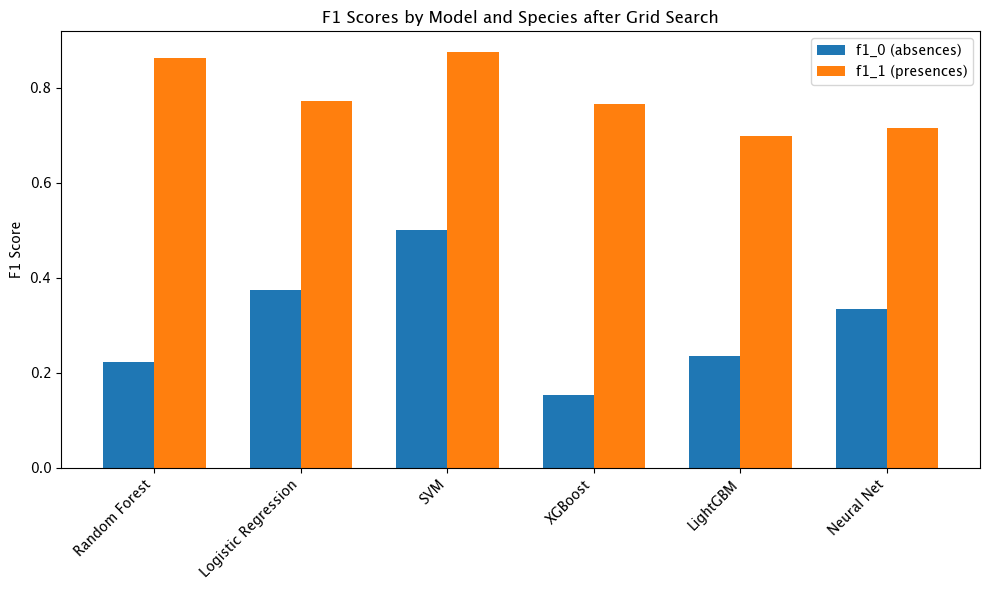


=== Best Parameters ===
                     class_weight  max_depth  n_estimators    C     solver  \
Random Forest        {0: 5, 1: 1}       10.0         100.0  NaN        NaN   
Logistic Regression  {0: 2, 1: 1}        NaN           NaN  1.0  liblinear   
SVM                  {0: 1, 1: 1}        NaN           NaN  1.0        NaN   
LightGBM             {0: 3, 1: 1}       10.0           NaN  NaN        NaN   
XGBoost                       NaN        6.0         100.0  NaN        NaN   
Neural Net                    NaN        NaN           NaN  NaN        NaN   

                     kernel  learning_rate  scale_pos_weight  num_leaves  \
Random Forest           NaN            NaN               NaN         NaN   
Logistic Regression     NaN            NaN               NaN         NaN   
SVM                  linear            NaN               NaN         NaN   
LightGBM                NaN           0.01               NaN        31.0   
XGBoost                 NaN           0.10      

In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === PyTorch Feedforward NN ===
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# === Config ===
species_list = ['CORYCO', 'SEQUSE', 'QUERAG', 'ARBUME']
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

# === Parameter Grids ===
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            {0: 5, 1: 1}
        ]
    },
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],
        "solver": ["liblinear"],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            "balanced"
        ]
    },
    "SVM": {
        "C": [0.1, 1.0, 10.0],
        "kernel": ["rbf", "linear"],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            "balanced"
        ]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [6, 10],
        "learning_rate": [0.01, 0.1],
        "scale_pos_weight": [1, 2, 3, 5]
    },
    "LightGBM": {
        "num_leaves": [31, 63],
        "max_depth": [10, 20, -1],
        "learning_rate": [0.01, 0.1],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            "balanced"
        ]
    }
}


# === Model Suite ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "Neural Net": "pytorch"
}

results = []
best_params = {}

for name, model in models.items():
    print(f"Training {name}...")

    if name == "Neural Net":
        best_params[name] = {"note": "Custom PyTorch model, no grid search"}

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        net = FeedforwardNN(X_train.shape[1]).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
        weights = torch.tensor([3.0, 1.0], dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

        net.train()
        for epoch in range(20):
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(net(xb), yb)
                loss.backward()
                optimizer.step()

        net.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            logits = net(X_test_tensor)
            y_pred = torch.argmax(logits, dim=1).cpu().numpy()

    else:
        grid = GridSearchCV(model, param_grids[name], cv=3, scoring='f1_macro')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params[name] = grid.best_params_

        y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results.append({
        "model": name,
        "f1_0": report.get("0", {}).get("f1-score", 0),
        "f1_1": report.get("1", {}).get("f1-score", 0),
        "accuracy": report.get("accuracy", 0)
    })


# === Display Results ===
results_df = pd.DataFrame(results)
best_params_df = pd.DataFrame.from_dict(best_params, orient="index")

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

ax.bar(x - width / 2, results_df["f1_0"], width, label="f1_0 (absences)")
ax.bar(x + width / 2, results_df["f1_1"], width, label="f1_1 (presences)")

ax.set_xticks(x)
ax.set_xticklabels(results_df["model"], rotation=45, ha="right")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Scores by Model and Species after Grid Search")
ax.legend()
plt.tight_layout()
plt.show()

print("\n=== Best Parameters ===")
print(best_params_df)
print("\n=== Performance Metrics ===")
print(results_df)


Training Random Forest...
Training Logistic Regression...
Training SVM...
Training XGBoost...
Training LightGBM...
Training Neural Net...


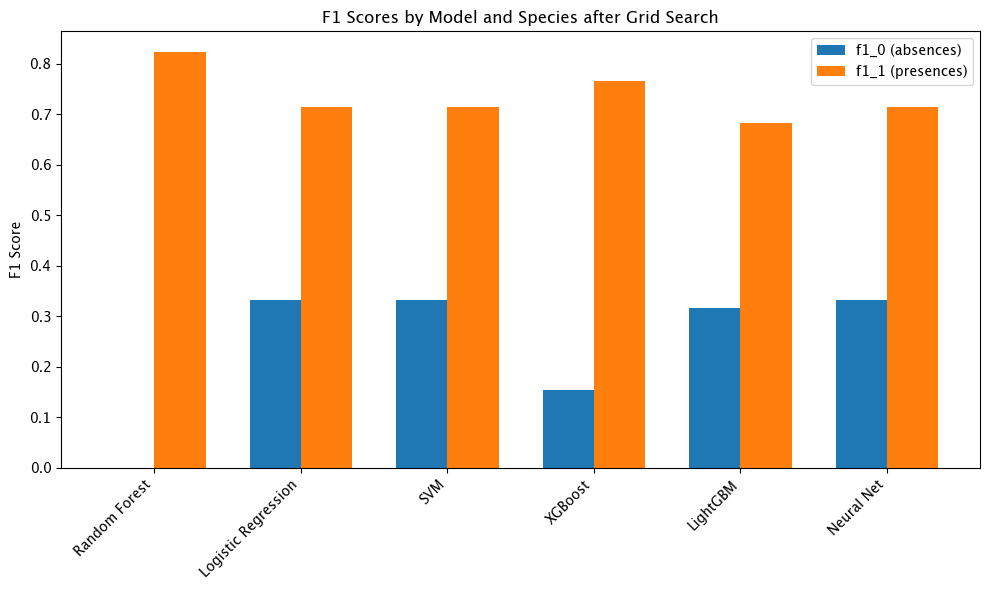


=== Best Parameters ===
                     class_weight  max_depth  n_estimators    C     solver  \
Random Forest        {0: 1, 1: 1}       10.0         200.0  NaN        NaN   
Logistic Regression  {0: 2, 1: 1}        NaN           NaN  0.1  liblinear   
SVM                  {0: 3, 1: 1}        NaN           NaN  0.1        NaN   
LightGBM                 balanced       10.0           NaN  NaN        NaN   
XGBoost                       NaN        6.0         100.0  NaN        NaN   
Neural Net                    NaN        NaN           NaN  NaN        NaN   

                     kernel  learning_rate  scale_pos_weight  num_leaves  \
Random Forest           NaN            NaN               NaN         NaN   
Logistic Regression     NaN            NaN               NaN         NaN   
SVM                  linear            NaN               NaN         NaN   
LightGBM                NaN           0.01               NaN        31.0   
XGBoost                 NaN           0.10      

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === PyTorch Feedforward NN ===
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# === Config ===
species_list = ['CORYCO', 'SEQUSE', 'QUERAG', 'ARBUME']
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

# === Parameter Grids ===
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            {0: 5, 1: 1}
        ]
    },
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],
        "solver": ["liblinear"],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            "balanced"
        ]
    },
    "SVM": {
        "C": [0.1, 1.0, 10.0],
        "kernel": ["rbf", "linear"],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            "balanced"
        ]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [6, 10],
        "learning_rate": [0.01, 0.1],
        "scale_pos_weight": [1, 2, 3, 5]
    },
    "LightGBM": {
        "num_leaves": [31, 63],
        "max_depth": [10, 20, -1],
        "learning_rate": [0.01, 0.1],
        "class_weight": [
            {0: 1, 1: 1},
            {0: 2, 1: 1},
            {0: 3, 1: 1},
            "balanced"
        ]
    }
}


# === Model Suite ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "Neural Net": "pytorch"
}

results = []
best_params = {}

for name, model in models.items():
    print(f"Training {name}...")

    if name == "Neural Net":
        best_params[name] = {"note": "Custom PyTorch model, no grid search"}

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        net = FeedforwardNN(X_train.shape[1]).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
        weights = torch.tensor([3.0, 1.0], dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

        net.train()
        for epoch in range(20):
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(net(xb), yb)
                loss.backward()
                optimizer.step()

        net.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
            logits = net(X_test_tensor)
            y_pred = torch.argmax(logits, dim=1).cpu().numpy()

    else:
        grid = GridSearchCV(model, param_grids[name], cv=3, scoring='recall_macro')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params[name] = grid.best_params_

        y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results.append({
        "model": name,
        "f1_0": report.get("0", {}).get("f1-score", 0),
        "f1_1": report.get("1", {}).get("f1-score", 0),
        "accuracy": report.get("accuracy", 0)
    })


# === Display Results ===
results_df = pd.DataFrame(results)
best_params_df = pd.DataFrame.from_dict(best_params, orient="index")

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

ax.bar(x - width / 2, results_df["f1_0"], width, label="f1_0 (absences)")
ax.bar(x + width / 2, results_df["f1_1"], width, label="f1_1 (presences)")

ax.set_xticks(x)
ax.set_xticklabels(results_df["model"], rotation=45, ha="right")
ax.set_ylabel("F1 Score")
ax.set_title("F1 Scores by Model and Species after Grid Search")
ax.legend()
plt.tight_layout()
plt.show()

print("\n=== Best Parameters ===")
print(best_params_df)
print("\n=== Performance Metrics ===")
print(results_df)


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === PyTorch Feedforward NN ===
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# === Config ===
species_list = ['CORYCO', 'SEQUSE', 'QUERAG', 'ARBUME']
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

# === Parameter Grids ===
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, {0: 5, 1: 1}]
    },
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],
        "solver": ["liblinear"],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, "balanced"]
    },
    "SVM": {
        "C": [0.1, 1.0, 10.0],
        "kernel": ["rbf", "linear"],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, "balanced"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [6, 10],
        "learning_rate": [0.01, 0.1],
        "scale_pos_weight": [1, 2, 3, 5]
    },
    "LightGBM": {
        "num_leaves": [31, 63],
        "max_depth": [10, 20, -1],
        "learning_rate": [0.01, 0.1],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, "balanced"]
    }
}

# === Model Suite ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "Neural Net": "pytorch"
}

all_results = []
all_best_params = []

for species in species_list:
    print(f"\n=== Species: {species} ===")

    if species not in grid.columns:
        print(f"Species {species} not in grid. Skipping.")
        continue

    # === Label preparation ===
    grid["y_true"] = (grid[species] > 0).astype(int)
    y = grid["y_true"].values

    # === Raster sampling at centroid ===
    centroids = grid.geometry.centroid
    xs, ys = centroids.x.values, centroids.y.values
    rows, cols = rasterio.transform.rowcol(transform, xs, ys)
    rows = np.clip(rows, 0, image.shape[1] - 1)
    cols = np.clip(cols, 0, image.shape[2] - 1)
    X = np.stack([image[band, rows, cols] for band in range(image.shape[0])], axis=1)

    # === Remove NaNs ===
    valid_mask = np.isfinite(X).all(axis=1)
    X = X[valid_mask]
    y = y[valid_mask]
    grid_valid = grid[valid_mask].copy()

    # === Scale features ===
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # === Split data ===
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    species_results = []
    species_best_params = {}

    for name, model in models.items():
        print(f"Training {name} for {species}...")

        if name == "Neural Net":
            species_best_params[name] = {"note": "Custom PyTorch model, no grid search"}

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            net = FeedforwardNN(X_train.shape[1]).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
            weights = torch.tensor([3.0, 1.0], dtype=torch.float32).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)

            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.long)
            loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

            net.train()
            for epoch in range(20):
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    loss = criterion(net(xb), yb)
                    loss.backward()
                    optimizer.step()

            net.eval()
            with torch.no_grad():
                X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
                logits = net(X_test_tensor)
                y_pred = torch.argmax(logits, dim=1).cpu().numpy()

        else:
            grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='f1_macro')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            species_best_params[name] = grid_search.best_params_
            y_pred = best_model.predict(X_test)

        from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

        # ROC AUC (handle models that support predict_proba or decision_function)
        try:
            if name == "Neural Net":
                probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].cpu().numpy()
            elif hasattr(best_model, "predict_proba"):
                probs = best_model.predict_proba(X_test)[:, 1]
            elif hasattr(best_model, "decision_function"):
                probs = best_model.decision_function(X_test)
            else:
                probs = y_pred  # fallback if needed
            roc_auc = roc_auc_score(y_test, probs)
        except Exception:
            roc_auc = np.nan

        # Append results
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        species_results.append({
            "species": species,
            "model": name,
            "f1_0": report.get("0", {}).get("f1-score", 0),
            "f1_1": report.get("1", {}).get("f1-score", 0),
            "accuracy": report.get("accuracy", 0),
            "roc_auc": roc_auc
        })

        # Store confusion matrix data
        if "conf_matrices" not in locals():
            conf_matrices = []
        conf_matrices.append((species, name, y_test, y_pred))


    all_results.extend(species_results)
    flat = {}
    for model_name, params in species_best_params.items():
        if isinstance(params, dict):
            for param_name, value in params.items():
                flat[f"{model_name}__{param_name}"] = value
        else:
            flat[f"{model_name}__note"] = params
    all_best_params.append(pd.DataFrame([flat], index=[species]))


# === Display Results ===
results_df = pd.DataFrame(all_results)
best_params_df = pd.concat(all_best_params)

fig, ax = plt.subplots(figsize=(12, 6))
x_labels = results_df['species'] + " - " + results_df['model']
x = np.arange(len(x_labels))
width = 0.35

ax.bar(x - width / 2, results_df["f1_0"], width, label="f1_0 (absences)")
ax.bar(x + width / 2, results_df["f1_1"], width, label="f1_1 (presences)")

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=90)
ax.set_ylabel("F1 Score")
ax.set_title("F1 Scores by Model and Species")
ax.legend()
plt.tight_layout()
plt.show()

print("\n=== Best Parameters ===")
print(best_params_df)
print("\n=== Performance Metrics ===")
print(results_df)
print("\n=== Performance Metrics ===")
print(results_df[["species", "model", "f1_0", "f1_1", "accuracy", "roc_auc"]])



=== Species: CORYCO ===
Training Random Forest for CORYCO...
Training Logistic Regression for CORYCO...
Training SVM for CORYCO...
Training XGBoost for CORYCO...


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot all confusion matrices in a grid
n_species = len(species_list)
n_models = len(models)
fig, axes = plt.subplots(n_species, n_models, figsize=(4.5 * n_models, 4 * n_species))

for i, (species, model, y_true, y_pred) in enumerate(conf_matrices):
    row = species_list.index(species)
    col = list(models.keys()).index(model)
    ax = axes[row, col] if n_species > 1 else axes[col]
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, ax=ax, cmap="Blues", colorbar=False
    )
    ax.set_title(f"{species} – {model}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.suptitle("Confusion Matrices by Species × Model", fontsize=16, y=1.02)
plt.show()



=== Species: CORYCO ===
Training Random Forest for CORYCO...
Training Logistic Regression for CORYCO...
Training SVM for CORYCO...
Training XGBoost for CORYCO...
Training LightGBM for CORYCO...
Training Neural Net for CORYCO...

=== Species: SEQUSE ===
Training Random Forest for SEQUSE...
Training Logistic Regression for SEQUSE...
Training SVM for SEQUSE...
Training XGBoost for SEQUSE...
Training LightGBM for SEQUSE...
Training Neural Net for SEQUSE...

=== Species: QUERAG ===
Training Random Forest for QUERAG...
Training Logistic Regression for QUERAG...
Training SVM for QUERAG...
Training XGBoost for QUERAG...
Training LightGBM for QUERAG...
Training Neural Net for QUERAG...

=== Species: ARBUME ===
Training Random Forest for ARBUME...
Training Logistic Regression for ARBUME...
Training SVM for ARBUME...
Training XGBoost for ARBUME...
Training LightGBM for ARBUME...
Training Neural Net for ARBUME...


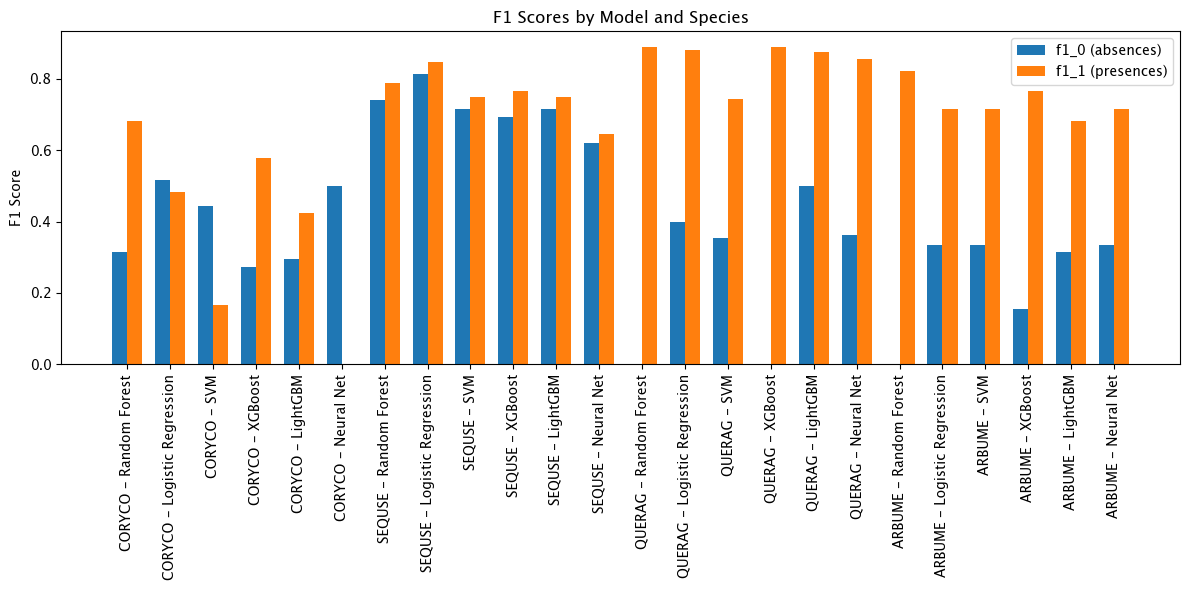


=== Best Parameters ===
       Random Forest__class_weight  Random Forest__max_depth  \
CORYCO                {0: 1, 1: 1}                        10   
SEQUSE                {0: 2, 1: 1}                        10   
QUERAG                {0: 1, 1: 1}                        10   
ARBUME                {0: 1, 1: 1}                        10   

        Random Forest__n_estimators  Logistic Regression__C  \
CORYCO                          200                     1.0   
SEQUSE                          100                     1.0   
QUERAG                          100                     0.1   
ARBUME                          200                     0.1   

       Logistic Regression__class_weight Logistic Regression__solver  SVM__C  \
CORYCO                      {0: 3, 1: 1}                   liblinear     0.1   
SEQUSE                          balanced                   liblinear     1.0   
QUERAG                      {0: 3, 1: 1}                   liblinear     0.1   
ARBUME            

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === PyTorch Feedforward NN ===
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

# === Config ===
species_list = ['CORYCO', 'SEQUSE', 'QUERAG', 'ARBUME']
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

# === Parameter Grids ===
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, {0: 5, 1: 1}]
    },
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],
        "solver": ["liblinear"],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, "balanced"]
    },
    "SVM": {
        "C": [0.1, 1.0, 10.0],
        "kernel": ["rbf", "linear"],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, "balanced"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [6, 10],
        "learning_rate": [0.01, 0.1],
        "scale_pos_weight": [1, 2, 3, 5]
    },
    "LightGBM": {
        "num_leaves": [31, 63],
        "max_depth": [10, 20, -1],
        "learning_rate": [0.01, 0.1],
        "class_weight": [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 3, 1: 1}, "balanced"]
    }
}

# === Model Suite ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=0),
    "LightGBM": LGBMClassifier(verbosity=-1),
    "Neural Net": "pytorch"
}

all_results = []
all_best_params = []

for species in species_list:
    print(f"\n=== Species: {species} ===")

    if species not in grid.columns:
        print(f"Species {species} not in grid. Skipping.")
        continue

    # === Label preparation ===
    grid["y_true"] = (grid[species] > 0).astype(int)
    y = grid["y_true"].values

    # === Raster sampling at centroid ===
    centroids = grid.geometry.centroid
    xs, ys = centroids.x.values, centroids.y.values
    rows, cols = rasterio.transform.rowcol(transform, xs, ys)
    rows = np.clip(rows, 0, image.shape[1] - 1)
    cols = np.clip(cols, 0, image.shape[2] - 1)
    X = np.stack([image[band, rows, cols] for band in range(image.shape[0])], axis=1)

    # === Remove NaNs ===
    valid_mask = np.isfinite(X).all(axis=1)
    X = X[valid_mask]
    y = y[valid_mask]
    grid_valid = grid[valid_mask].copy()

    # === Scale features ===
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # === Split data ===
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    species_results = []
    species_best_params = {}

    for name, model in models.items():
        print(f"Training {name} for {species}...")

        if name == "Neural Net":
            species_best_params[name] = {"note": "Custom PyTorch model, no grid search"}

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            net = FeedforwardNN(X_train.shape[1]).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
            weights = torch.tensor([3.0, 1.0], dtype=torch.float32).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)

            X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
            y_train_tensor = torch.tensor(y_train, dtype=torch.long)
            loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

            net.train()
            for epoch in range(20):
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    loss = criterion(net(xb), yb)
                    loss.backward()
                    optimizer.step()

            net.eval()
            with torch.no_grad():
                X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
                logits = net(X_test_tensor)
                y_pred = torch.argmax(logits, dim=1).cpu().numpy()

        else:
            grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='recall_macro')
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            species_best_params[name] = grid_search.best_params_
            y_pred = best_model.predict(X_test)

        # report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        # species_results.append({
        #     "species": species,
        #     "model": name,
        #     "f1_0": report.get("0", {}).get("f1-score", 0),
        #     "f1_1": report.get("1", {}).get("f1-score", 0),
        #     "accuracy": report.get("accuracy", 0)
        # })

        from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

        # ROC AUC (handle models that support predict_proba or decision_function)
        try:
            if name == "Neural Net":
                probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].cpu().numpy()
            elif hasattr(best_model, "predict_proba"):
                probs = best_model.predict_proba(X_test)[:, 1]
            elif hasattr(best_model, "decision_function"):
                probs = best_model.decision_function(X_test)
            else:
                probs = y_pred  # fallback if needed
            roc_auc = roc_auc_score(y_test, probs)
        except Exception:
            roc_auc = np.nan

        # Append results
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        species_results.append({
            "species": species,
            "model": name,
            "f1_0": report.get("0", {}).get("f1-score", 0),
            "f1_1": report.get("1", {}).get("f1-score", 0),
            "accuracy": report.get("accuracy", 0),
            "roc_auc": roc_auc
        })

        # Store confusion matrix data
        if "conf_matrices" not in locals():
            conf_matrices = []
        conf_matrices.append((species, name, y_test, y_pred))







    all_results.extend(species_results)
    flat = {}
    for model_name, params in species_best_params.items():
        if isinstance(params, dict):
            for param_name, value in params.items():
                flat[f"{model_name}__{param_name}"] = value
        else:
            flat[f"{model_name}__note"] = params
    all_best_params.append(pd.DataFrame([flat], index=[species]))


# === Display Results ===
results_df = pd.DataFrame(all_results)
best_params_df = pd.concat(all_best_params)

fig, ax = plt.subplots(figsize=(12, 6))
x_labels = results_df['species'] + " - " + results_df['model']
x = np.arange(len(x_labels))
width = 0.35

ax.bar(x - width / 2, results_df["f1_0"], width, label="f1_0 (absences)")
ax.bar(x + width / 2, results_df["f1_1"], width, label="f1_1 (presences)")

ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=90)
ax.set_ylabel("F1 Score")
ax.set_title("F1 Scores by Model and Species")
ax.legend()
plt.tight_layout()
plt.show()

print("\n=== Best Parameters ===")
print(best_params_df)
print("\n=== Performance Metrics ===")
print(results_df)
print("\n=== Performance Metrics ===")
print(results_df[["species", "model", "f1_0", "f1_1", "accuracy", "roc_auc"]])


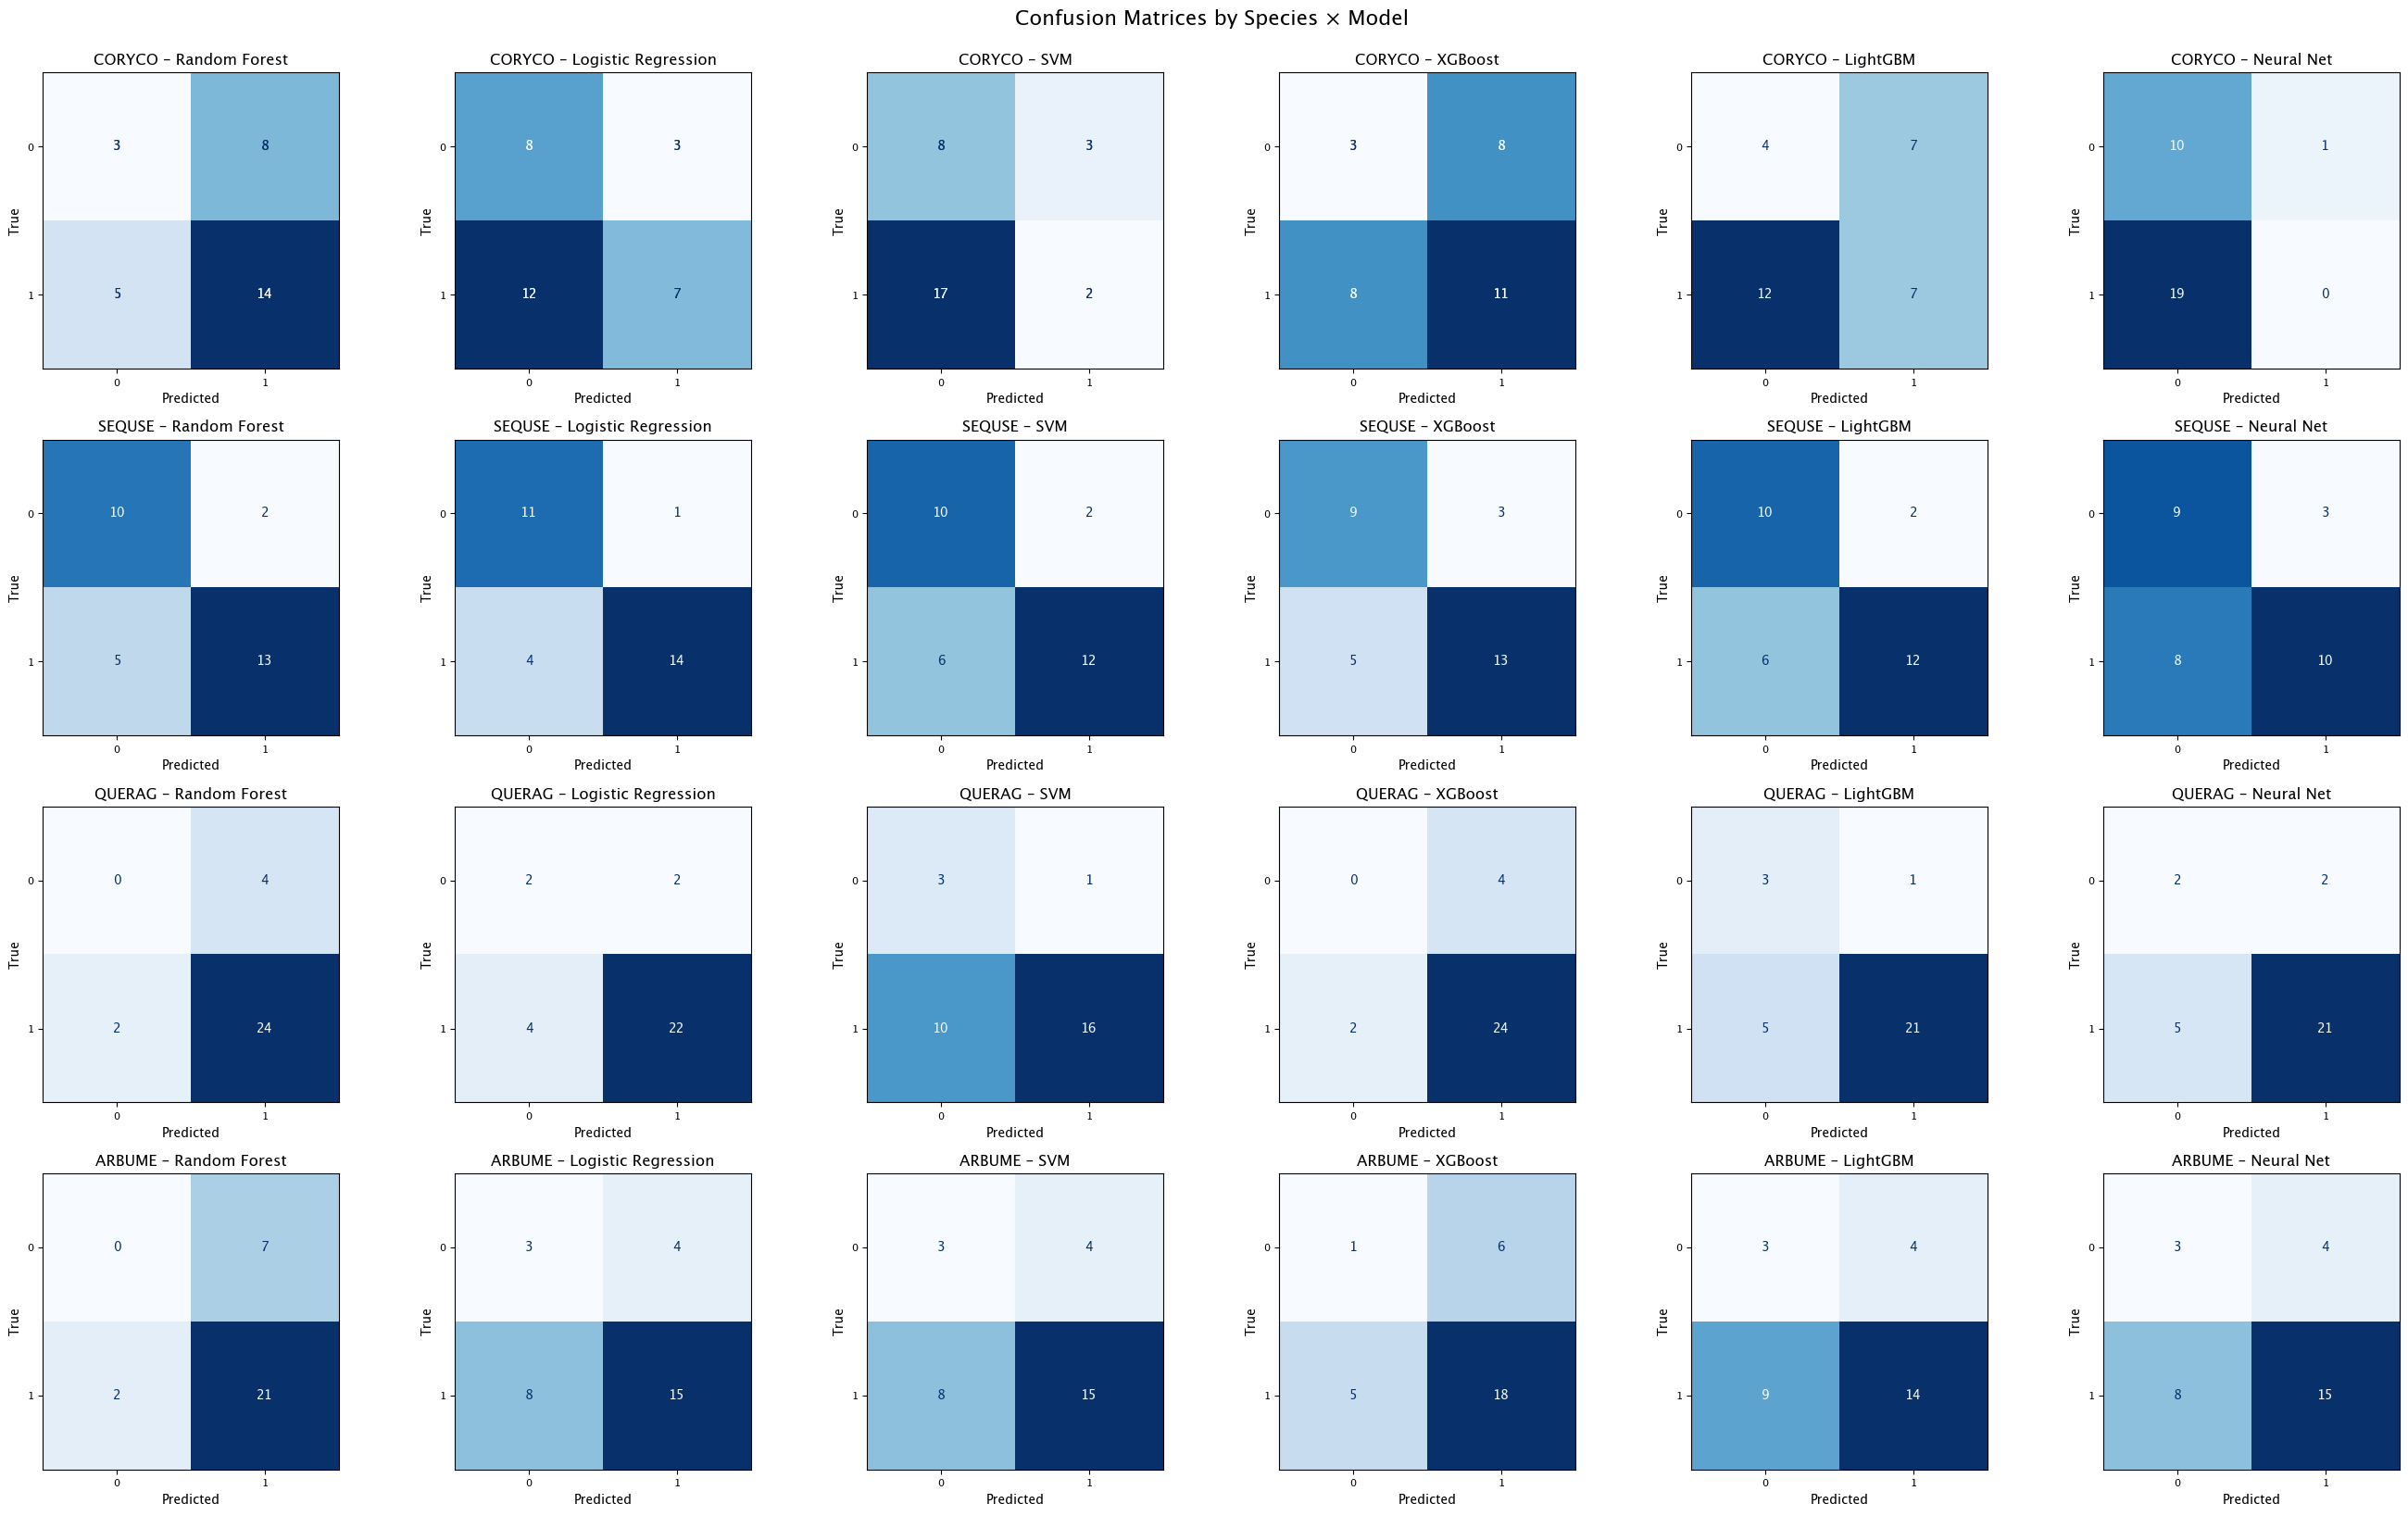

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot all confusion matrices in a grid
n_species = len(species_list)
n_models = len(models)
fig, axes = plt.subplots(n_species, n_models, figsize=(4.5 * n_models, 4 * n_species))

for i, (species, model, y_true, y_pred) in enumerate(conf_matrices):
    row = species_list.index(species)
    col = list(models.keys()).index(model)
    ax = axes[row, col] if n_species > 1 else axes[col]
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, ax=ax, cmap="Blues", colorbar=False
    )
    ax.set_title(f"{species} – {model}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.suptitle("Confusion Matrices by Species × Model", fontsize=16, y=1.02)
plt.show()
